In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, WhiteKernel
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


# Data Cleaning
creating matching data frame that will include matching hotel names, ttt, los combination
the price difference between both scraped csv files will be calculated as well

In [83]:
expedia_df = pd.read_csv('Data/combined_expedia_results.csv')
booking_df = pd.read_csv('TaskB - Booking/merged_booking_final.csv')

#clean hotel names
expedia_df['hotel_name_clean'] = expedia_df['Hotel Name'].str.strip().str.lower()
booking_df['hotel_name_clean'] = booking_df['hotel_name'].str.strip().str.lower()

# creating matched dataframe that contains only shared hotel names with same ttt and los
matched_df = pd.merge(
    expedia_df[['hotel_name_clean', 'TTT', 'LOS']],
    booking_df[['hotel_name_clean', 'ttt', 'los']],
    left_on=['hotel_name_clean', 'TTT', 'LOS'],
    right_on=['hotel_name_clean', 'ttt', 'los'],
    how='inner'
)
print(f"Number of matched hotels: {len(matched_df)}")


Number of matched hotels: 26336


Creating matched expedia and booking files so we can test them.

In [84]:
expedia_matched = expedia_df.merge(
    matched_df[['hotel_name_clean', 'TTT', 'LOS']],
    on=['hotel_name_clean', 'TTT', 'LOS'],
    how='inner'
)

booking_matched = booking_df.merge(
    matched_df[['hotel_name_clean', 'ttt', 'los']],
    left_on=['hotel_name_clean', 'ttt', 'los'],
    right_on=['hotel_name_clean', 'ttt', 'los'],
    how='inner'
)

expedia_matched = expedia_matched.drop(columns=['hotel_name_clean'])
booking_matched = booking_matched.drop(columns=['hotel_name_clean'])

expedia_matched.to_csv('Data/matched_expedia.csv', index=False)
booking_matched.to_csv('Data/matched_booking.csv', index=False)

print(f"Matched Expedia dataset size: {len(expedia_matched)}")
print(f"Matched Booking dataset size: {len(booking_matched)}")
print(f"Number of unique matches: {len(matched_df)}")

Matched Expedia dataset size: 68084
Matched Booking dataset size: 61644
Number of unique matches: 26336


In [85]:
# After creating the matched datasets:

# 1. Check the sizes before deduplication
print(f"Expedia matched (before deduplication): {len(expedia_matched)}")
print(f"Booking matched (before deduplication): {len(booking_matched)}")

# 2. Sort by price so the lowest price for each combination comes first 
# Use the original hotel name columns for Expedia and Booking
expedia_matched = expedia_matched.sort_values(['Hotel Name', 'TTT', 'LOS', 'Price'])
booking_matched = booking_matched.sort_values(['hotel_name', 'ttt', 'los', 'price'])

# 3. Keep only the first occurrence of each hotel-TTT-LOS combination
expedia_matched = expedia_matched.drop_duplicates(subset=['Hotel Name', 'TTT', 'LOS'], keep='first')
booking_matched = booking_matched.drop_duplicates(subset=['hotel_name', 'ttt', 'los'], keep='first')

# 4. Now check the sizes again
print(f"Expedia matched (after deduplication): {len(expedia_matched)}")
print(f"Booking matched (after deduplication): {len(booking_matched)}")
print(f"Expected number of matches: {len(matched_df)}")

# 5. Now save the deduplicated datasets
expedia_matched.to_csv('Data/matched_expedia.csv', index=False)
booking_matched.to_csv('Data/matched_booking.csv', index=False)

Expedia matched (before deduplication): 68084
Booking matched (before deduplication): 61644
Expedia matched (after deduplication): 6484
Booking matched (after deduplication): 6484
Expected number of matches: 26336


### Since scrapping dates are not equal, remaining matched results are quite small

## Linear Regression

Price differences dataset created with 5706 records

Experiment 1: Using only TTT and LOS
     Metric         Value
0       MAE    143.581223
1       MSE  51623.970076
2      RMSE    227.209089
3  R² Score      0.141829


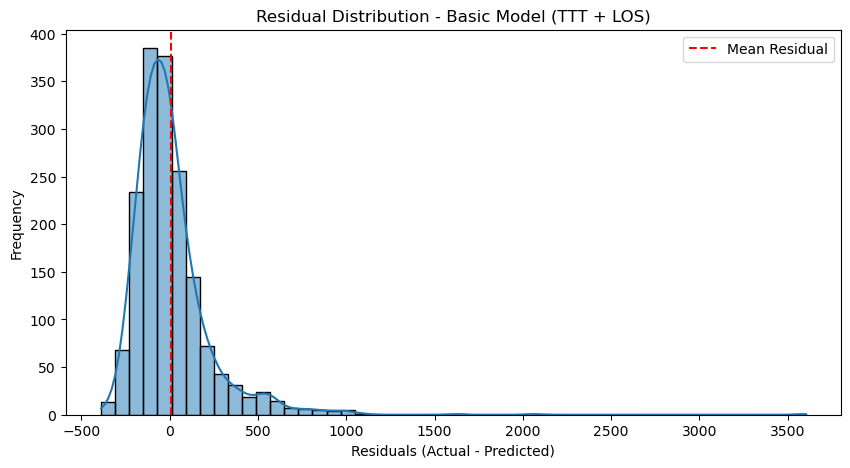


Experiment 2: Using only prices from both platforms
     Metric         Value
0       MAE     99.835962
1       MSE  22431.565210
2      RMSE    149.771710
3  R² Score      0.627109


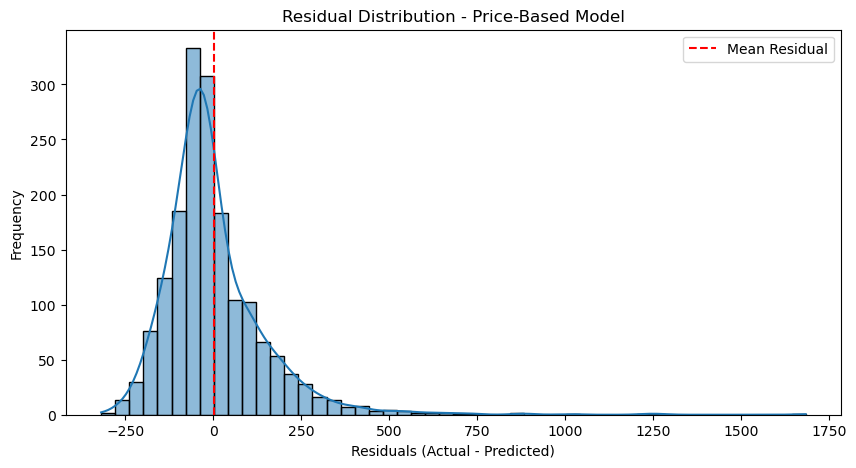


Experiment 3: Using all features
     Metric         Value
0       MAE     98.868833
1       MSE  21772.321276
2      RMSE    147.554469
3  R² Score      0.638068


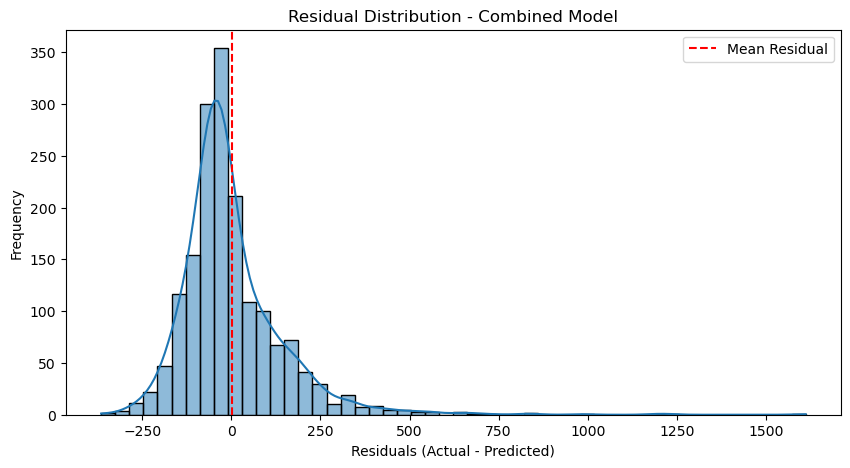


Experiment 4: Using standardized features
     Metric         Value
0       MAE     98.868833
1       MSE  21772.321276
2      RMSE    147.554469
3  R² Score      0.638068


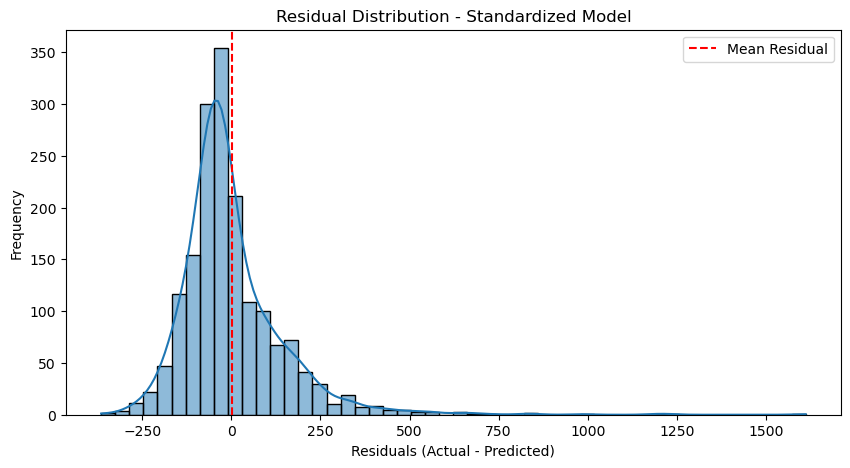


Summary of all experiments:
              Experiment         MAE        RMSE  R² Score
0         TTT + LOS Only  143.581223  227.209089  0.141829
1            Prices Only   99.835962  149.771710  0.627109
2      Combined Features   98.868833  147.554469  0.638068
3  Standardized Features   98.868833  147.554469  0.638068


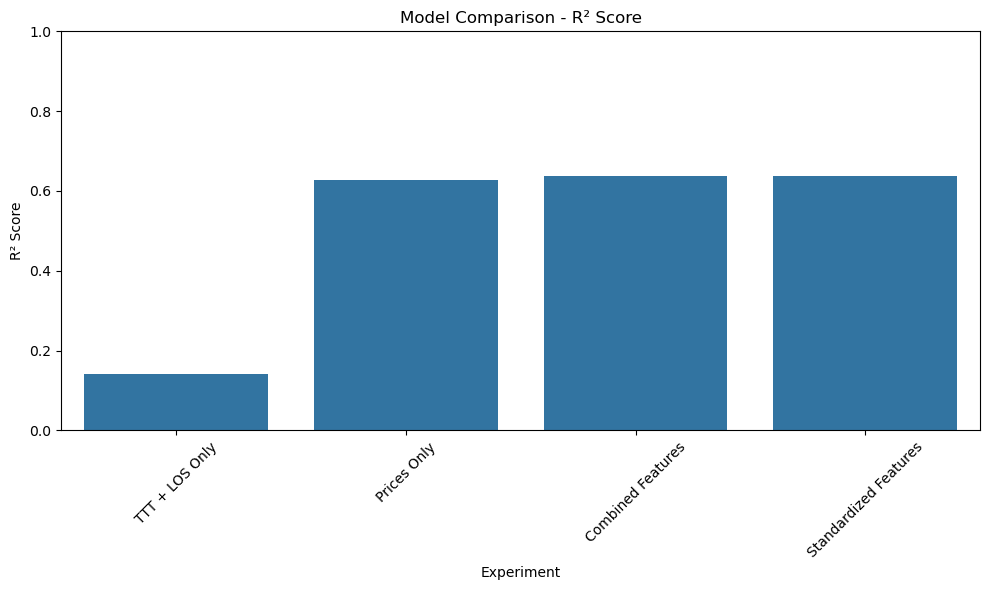

In [86]:


# 1. Load the matched datasets
expedia_df = pd.read_csv('Data/matched_expedia.csv')
booking_df = pd.read_csv('Data/matched_booking.csv')

# 2. Rename price columns to distinguish them
expedia_df.rename(columns={'Price': 'price_expedia'}, inplace=True)
booking_df.rename(columns={'price': 'price_booking'}, inplace=True)

# 3. Merge the datasets on hotel name, TTT/ttt, and LOS/los
price_diff_df = pd.merge(
    expedia_df[['Hotel Name', 'TTT', 'LOS', 'price_expedia']],
    booking_df[['hotel_name', 'ttt', 'los', 'price_booking']],
    left_on=['Hotel Name', 'TTT', 'LOS'],
    right_on=['hotel_name', 'ttt', 'los'],
    how='inner'
)

# 4. Calculate price differences and absolute price differences
price_diff_df['price_difference'] = price_diff_df['price_expedia'] - price_diff_df['price_booking']
price_diff_df['abs_price_difference'] = abs(price_diff_df['price_difference'])

# 5. Save the price differences dataset
price_diff_df.to_csv('Data/price_differences.csv', index=False)
print(f"Price differences dataset created with {len(price_diff_df)} records")

# Linear Regression function
def run_linear_regression(X, y, title):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create and train the linear regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = lr_model.predict(X_test)
    
    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Display results
    results_df = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
        "Value": [mae, mse, rmse, r2]
    })
    print(results_df)
    
    # Plot residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, bins=50, kde=True)
    plt.axvline(residuals.mean(), color='r', linestyle='dashed', label='Mean Residual')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    
    
    return lr_model, mae, mse, rmse, r2

# Define target variable - we'll predict the absolute price difference
y = price_diff_df['abs_price_difference']

# Experiment 1: Using only TTT,LOS parameters
print("\nExperiment 1: Using only TTT and LOS")
features1 = ['TTT', 'LOS']  # Using Expedia column names
X1 = price_diff_df[features1]
model1, mae1, mse1, rmse1, r2_1 = run_linear_regression(X1, y, "Basic Model (TTT + LOS)")

# Experiment 2: Using only prices
print("\nExperiment 2: Using only prices from both platforms")
features2 = ['price_booking', 'price_expedia']
X2 = price_diff_df[features2]
model2, mae2, mse2, rmse2, r2_2 = run_linear_regression(X2, y, "Price-Based Model")

# Experiment 3: Using all features
print("\nExperiment 3: Using all features")
features3 = ['TTT', 'LOS', 'price_booking', 'price_expedia']
X3 = price_diff_df[features3]
model3, mae3, mse3, rmse3, r2_3 = run_linear_regression(X3, y, "Combined Model")

# Experiment 4: Using standardized features
print("\nExperiment 4: Using standardized features")
scaler = StandardScaler()
X4_array = scaler.fit_transform(price_diff_df[features3])
X4_scaled = pd.DataFrame(X4_array, columns=features3)
model4, mae4, mse4, rmse4, r2_4 = run_linear_regression(X4_scaled, y, "Standardized Model")

# Summary table of all experiments
summary_df = pd.DataFrame({
    "Experiment": ["TTT + LOS Only", "Prices Only", "Combined Features", "Standardized Features"],
    "MAE": [mae1, mae2, mae3, mae4],
    "RMSE": [rmse1, rmse2, rmse3, rmse4],
    "R² Score": [r2_1, r2_2, r2_3, r2_4]
})

print("\nSummary of all experiments:")
print(summary_df)

# Visualize model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Experiment", y="R² Score", data=summary_df)
plt.title("Model Comparison - R² Score")
plt.ylim(0, 1)  # R² typically ranges from 0 to 1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Linear Regression Analysis Results

1. **Basic Model (TTT + LOS)**: produced poor predictive power (R² = 0.14), indicating that those features are insufficient to explain price variances between platforms.

2. **Price-Based Model**: Using just the prices from both platforms dramatically improved prediction accuracy (R² = 0.63), suggesting that pricing strategies have strong internal patterns across platforms.

3. **Combined Model** (TTT + LOS + prices): Adding booking parameters to the pricing data slightly improved the model (R² = 0.64), but the marginal gain was minimal.

4. **Standardized Model**: Standardizing all features produced identical results to the Combined Model, indicating that the scale of the features wasn't causing distortion in the model.

### Key Insights

- Linear regression is only appropriate when the variables have a strong linear relationship.

# Decision Tree


Decision Tree - max_depth=2
     Metric         Value
0       MAE    174.652398
1       MSE  62191.543746
2      RMSE    249.382324
3  R² Score      0.319771


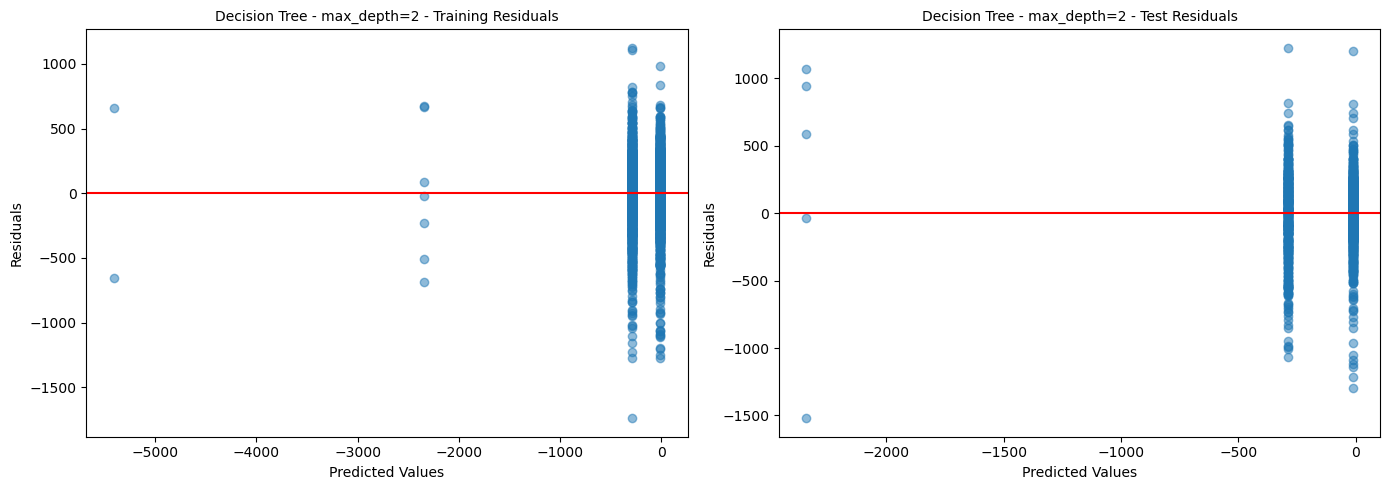

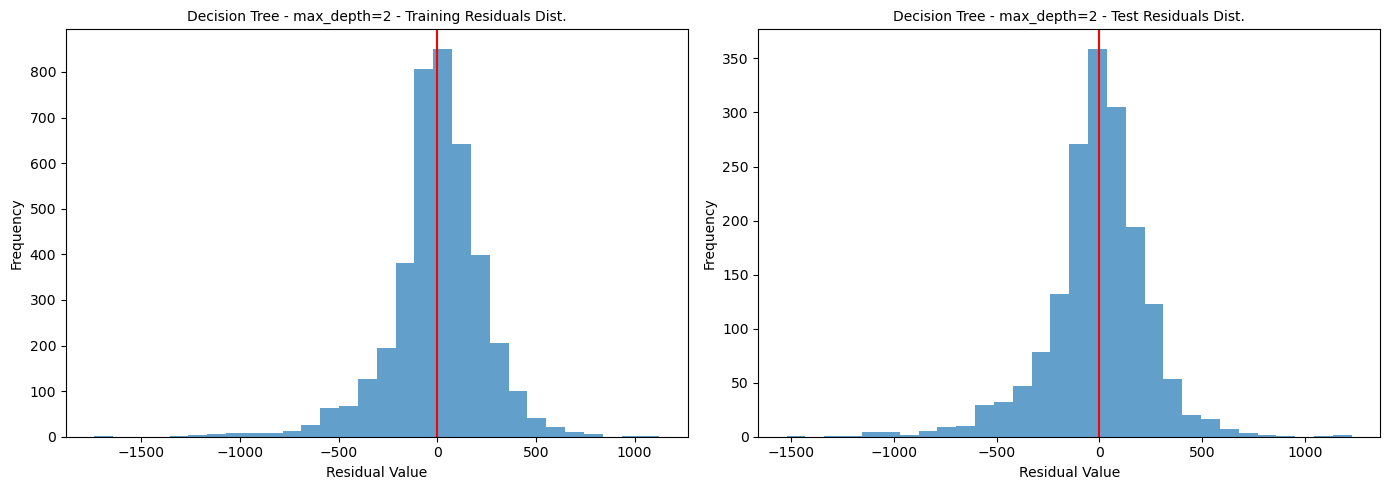


Decision Tree - max_depth=4
     Metric         Value
0       MAE    151.588809
1       MSE  45342.652814
2      RMSE    212.938143
3  R² Score      0.504058


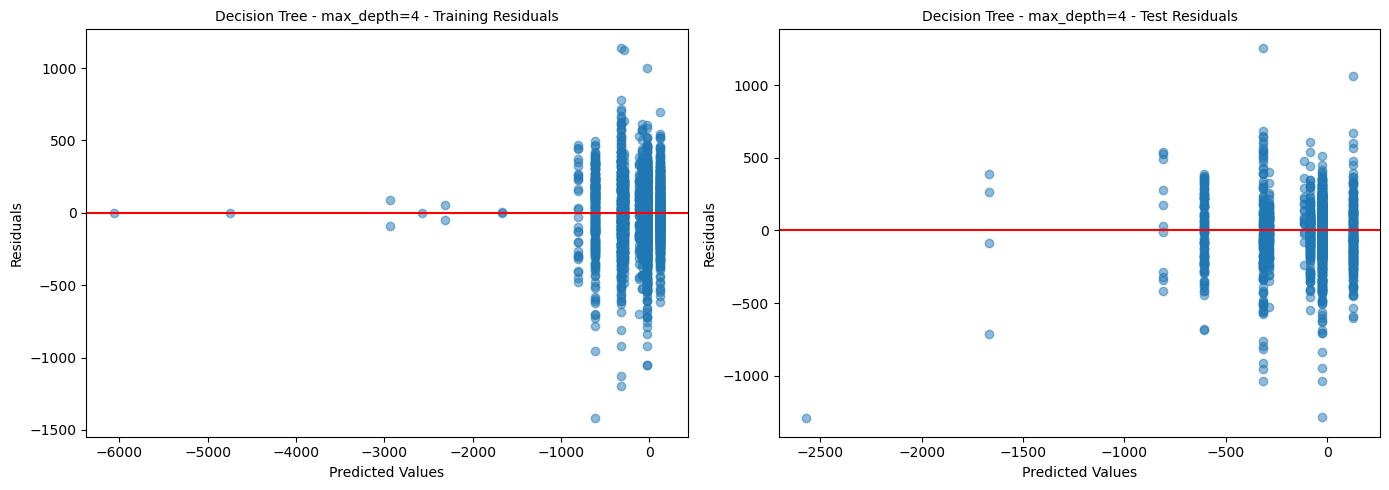

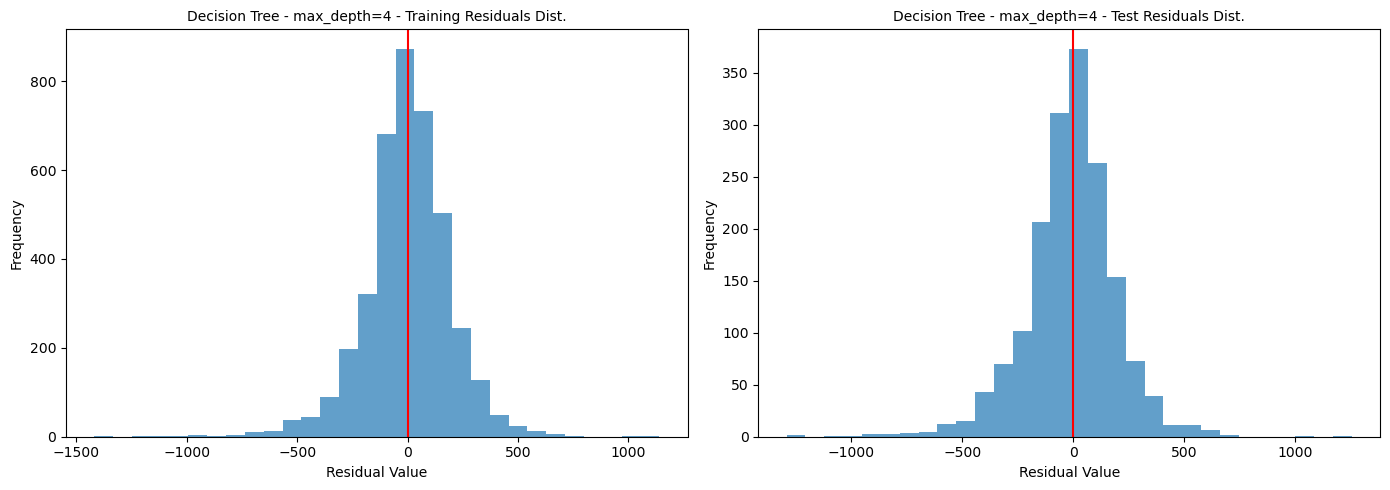


Decision Tree - max_depth=6
     Metric         Value
0       MAE    118.807911
1       MSE  25991.763448
2      RMSE    161.219612
3  R² Score      0.715712


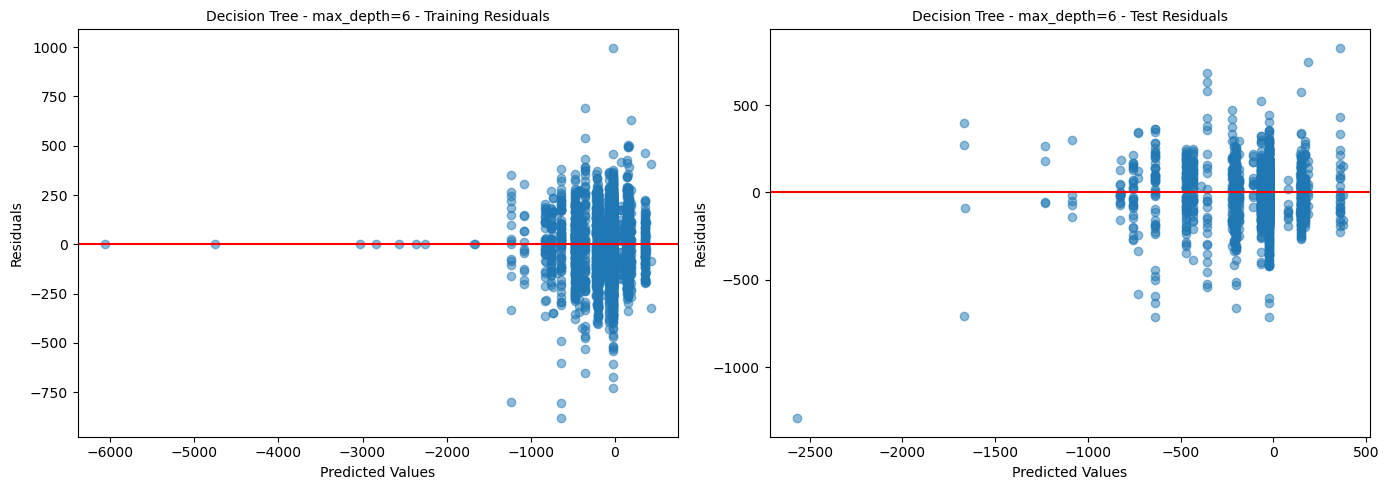

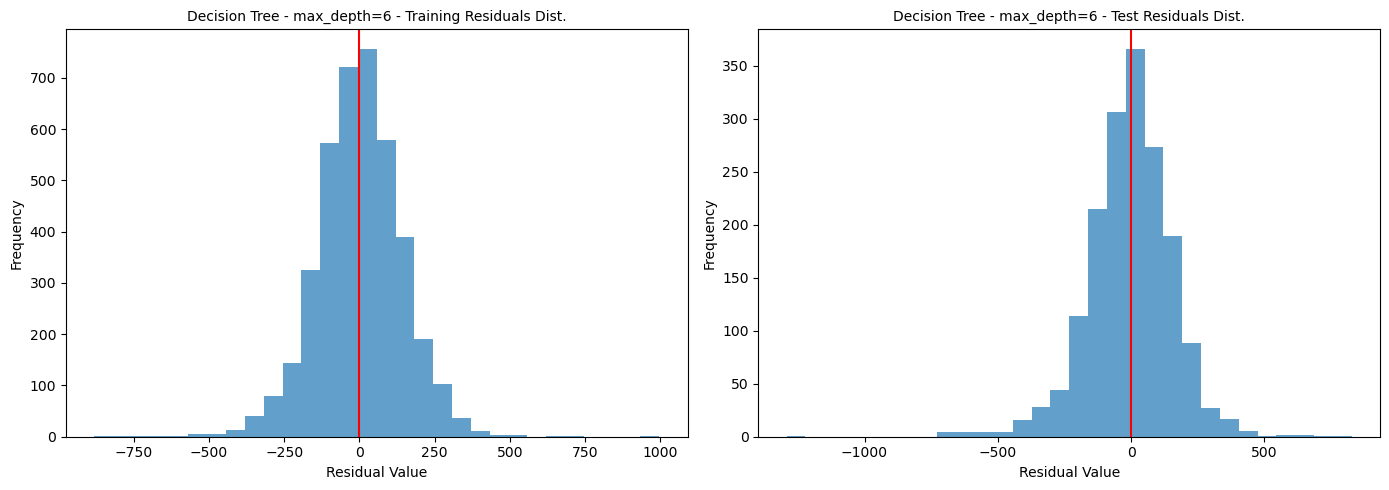


Decision Tree - min_samples_leaf=5
     Metric        Value
0       MAE    37.911217
1       MSE  7998.552649
2      RMSE    89.434628
3  R² Score     0.912515


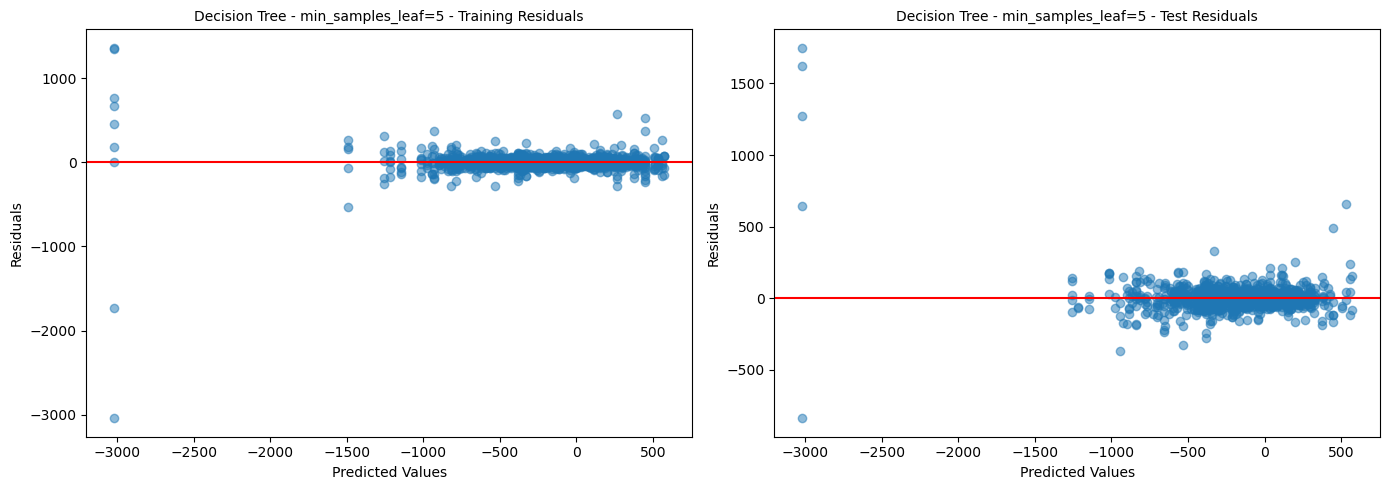

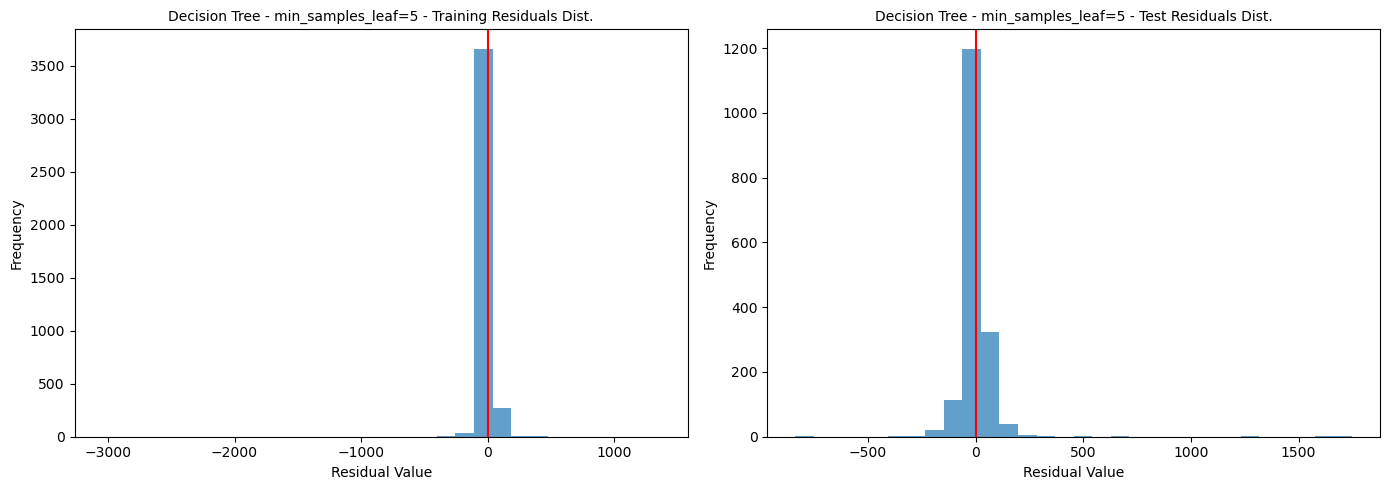


Decision Tree - min_samples_leaf=10
     Metric        Value
0       MAE    49.290519
1       MSE  9476.643025
2      RMSE    97.348051
3  R² Score     0.896348


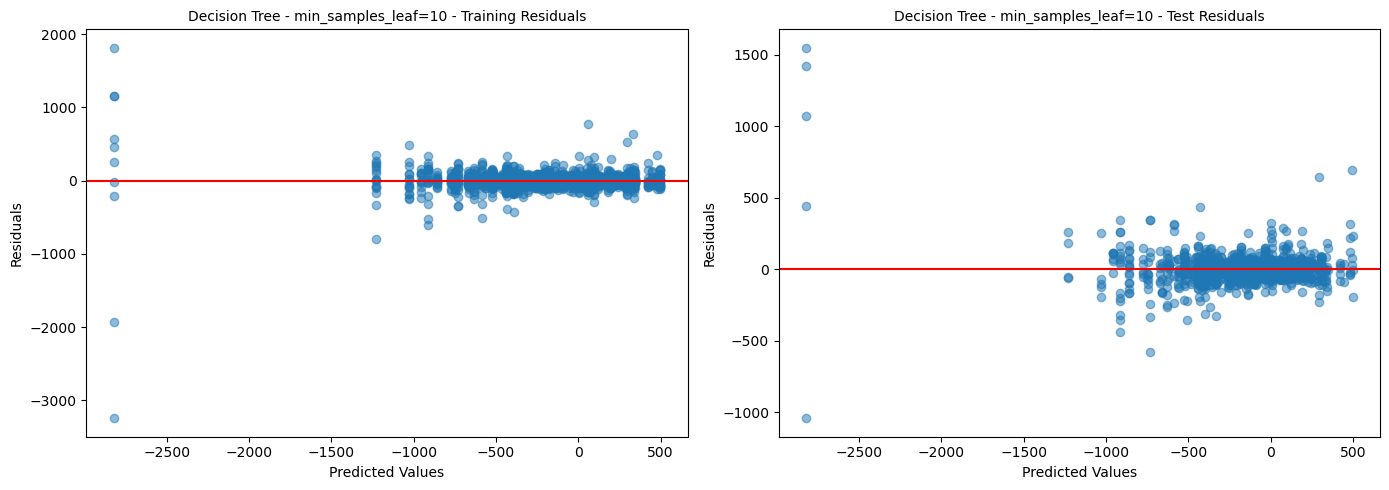

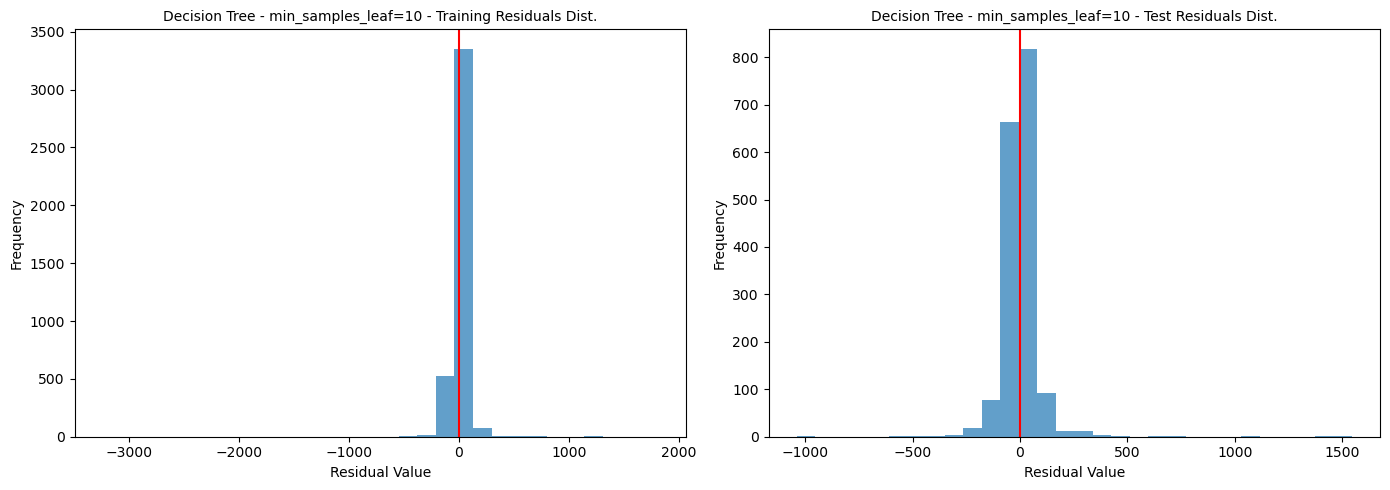


Decision Tree - min_samples_leaf=20
     Metric         Value
0       MAE     67.455218
1       MSE  15693.420950
2      RMSE    125.273385
3  R² Score      0.828351


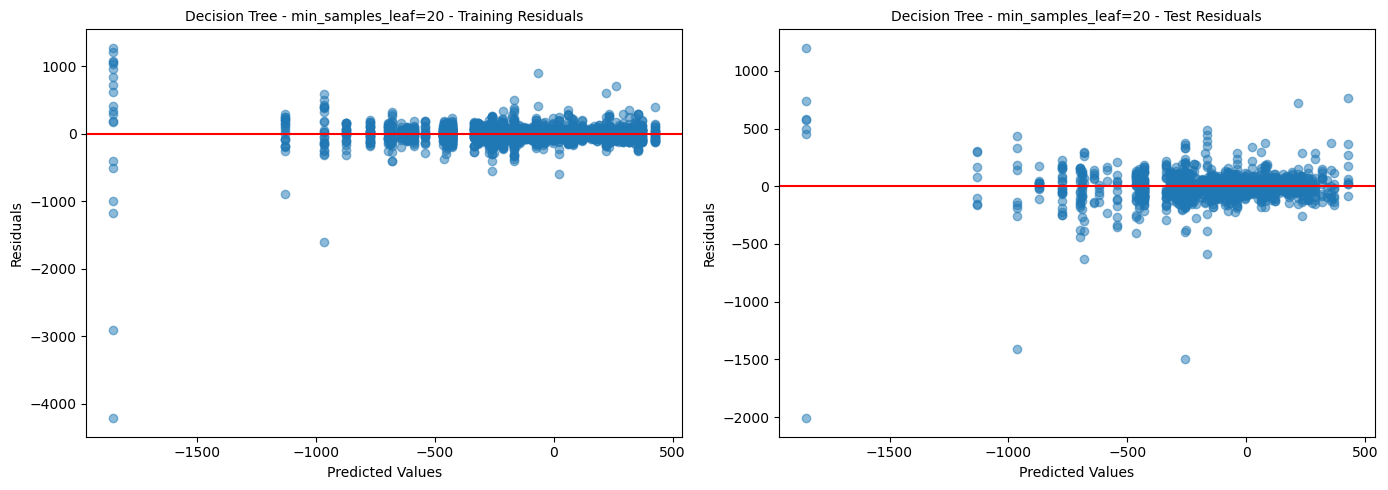

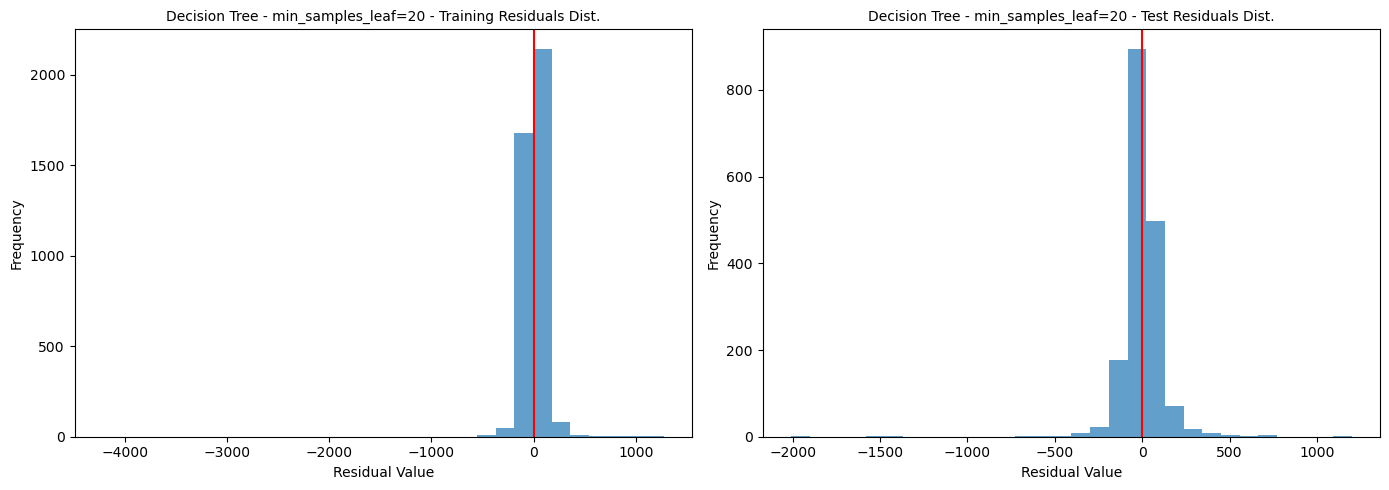


Decision Tree - max_depth=6, min_samples_leaf=5
     Metric         Value
0       MAE    120.544967
1       MSE  29424.944532
2      RMSE    171.537006
3  R² Score      0.678161


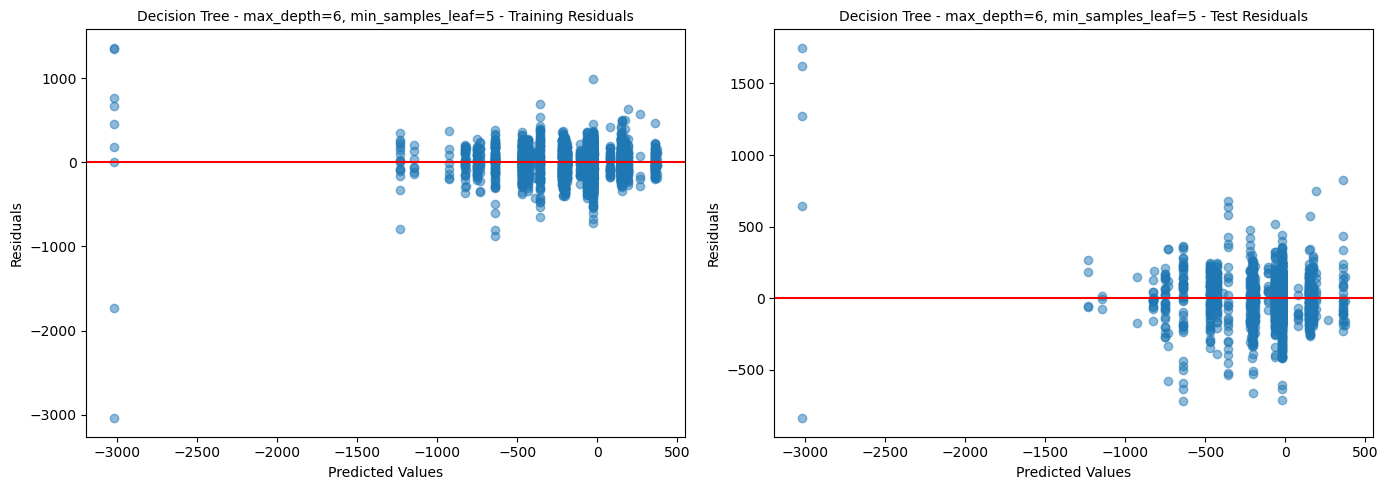

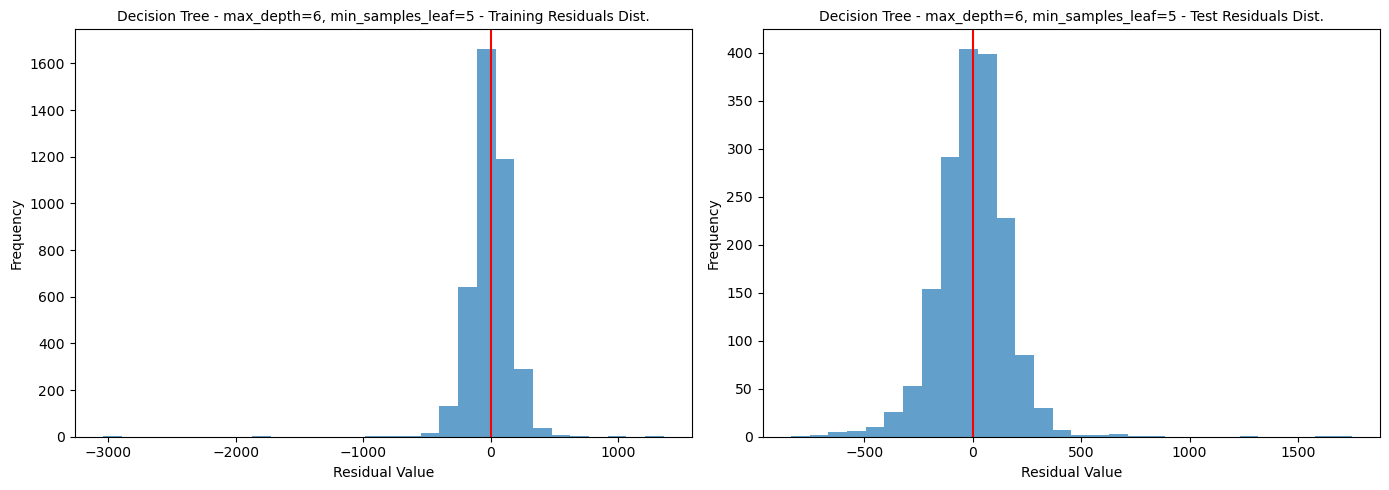


Decision Tree - max_depth=6, min_samples_leaf=10
     Metric         Value
0       MAE    120.769835
1       MSE  28671.024882
2      RMSE    169.325205
3  R² Score      0.686407


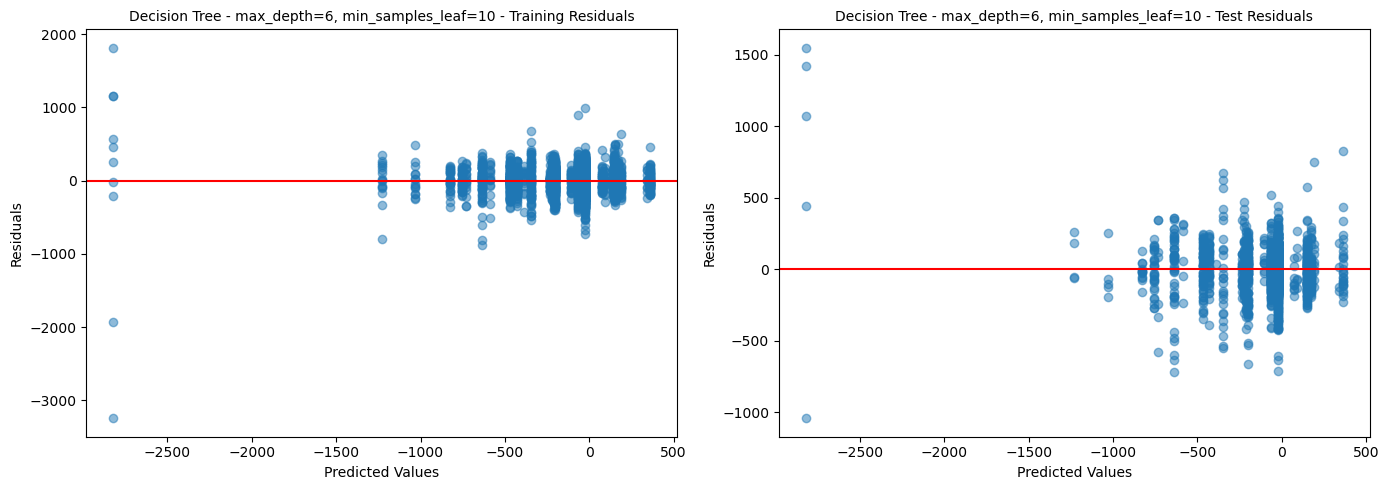

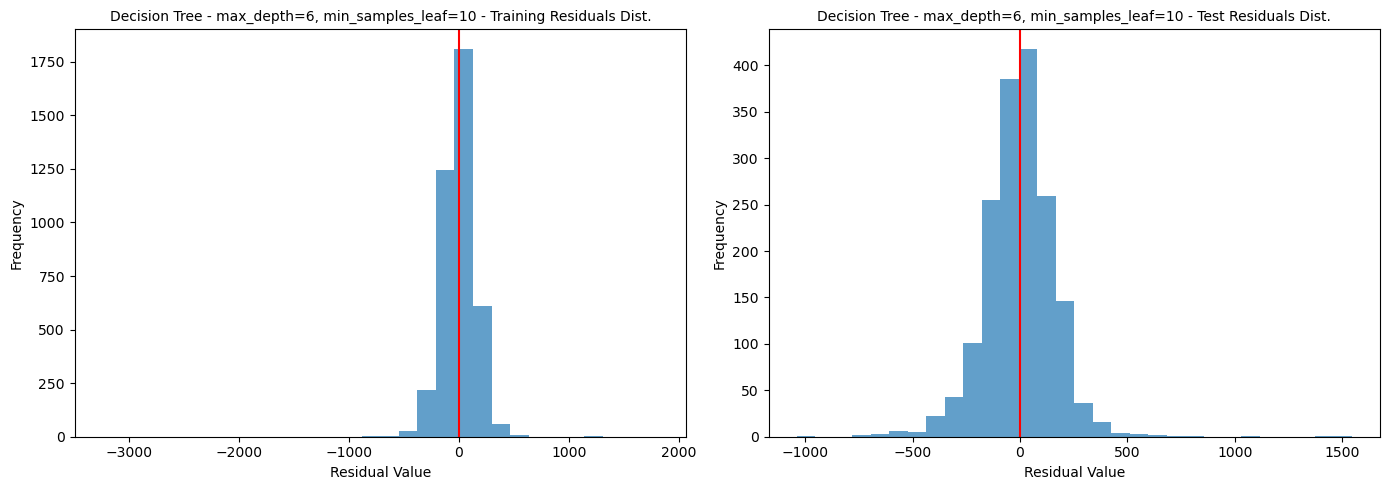

In [87]:
def decision_tree(max_depth=None, min_samples_leaf=1, title="Decision Tree"):
    
    df = pd.read_csv('Data/price_differences.csv')

    features = ['ttt', 'los', 'price_booking', 'price_expedia']
    y = df['price_difference']
    X = df[features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    dt_model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    dt_model.fit(X_train, y_train)
    
    # Make predictions on both train and test sets
    y_train_pred = dt_model.predict(X_train)
    y_test_pred = dt_model.predict(X_test)

    # Print title first
    print(f"\n{title}")
    
    # Calculate metrics
    mae_dt = mean_absolute_error(y_test, y_test_pred)
    mse_dt = mean_squared_error(y_test, y_test_pred)
    rmse_dt = np.sqrt(mse_dt)
    r2_dt = r2_score(y_test, y_test_pred)

    # Print metrics
    results_dt = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
        "Value": [mae_dt, mse_dt, rmse_dt, r2_dt]
    })
    print(results_dt)

    # Calculate residuals for both train and test sets
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    # Plot residuals
    plt.figure(figsize=(14, 5))
    
    # Training residuals
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred, residuals_train, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{title} - Training Residuals', fontsize=10)    
    
    # Test residuals
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_pred, residuals_test, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{title} - Test Residuals', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Plot a residual histogram
    plt.figure(figsize=(14, 5))  
    
    plt.subplot(1, 2, 1)
    plt.hist(residuals_train, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{title} - Training Residuals Dist.', fontsize=10)  
    
    plt.subplot(1, 2, 2)
    plt.hist(residuals_test, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{title} - Test Residuals Dist.', fontsize=10)  
    
    plt.tight_layout()
    plt.show()
    

# (max_depth)
decision_tree(max_depth=2, title="Decision Tree - max_depth=2")
decision_tree(max_depth=4, title="Decision Tree - max_depth=4")
decision_tree(max_depth=6, title="Decision Tree - max_depth=6")

# (min_samples_leaf)
decision_tree(min_samples_leaf=5, title="Decision Tree - min_samples_leaf=5")
decision_tree(min_samples_leaf=10, title="Decision Tree - min_samples_leaf=10")
decision_tree(min_samples_leaf=20, title="Decision Tree - min_samples_leaf=20")

# max_depth + min_samples_leaf
decision_tree(max_depth=6, min_samples_leaf=5, title="Decision Tree - max_depth=6, min_samples_leaf=5")
decision_tree(max_depth=6, min_samples_leaf=10, title="Decision Tree - max_depth=6, min_samples_leaf=10")

# Decision Tree Analysis Results

Looking at max_depth variations (2, 4, and 6), we observe that increasing tree depth substantially improves performance, with R² scores rising from 0.32 (depth=2) to 0.72 (depth=6). This indicates that the relationship between features and price differences is complex and requires deeper trees to capture effectively.

The combined model with max_depth=6 and min_samples_leaf=5 performed well (R²=0.68) but was surprisingly outperformed by models using only min_samples_leaf constraints. This suggests that limiting the minimum number of samples per leaf is more effective than limiting tree depth for this particular dataset, as it likely prevents overfitting while still allowing the model to capture important patterns in the data.

Overall, the optimal configuration appears to be min_samples_leaf=5, which achieved the highest R² score (0.91) and lowest RMSE (89.43), indicating that pruning the tree based on leaf size rather than depth offers the best balance between model complexity and predictive power for this price difference prediction task.

### Key Insights

- As we saw in previous project part, nonlinear models like Decision Tree that can identify more complex relationships between variables perform well, but tends to overfitting with large depth.

# Gaussian Regressor


GPR - RBF Kernel
     Metric       Value
0       MAE   18.059838
1       MSE  814.816894
2      RMSE   28.544998
3  R² Score    0.987695


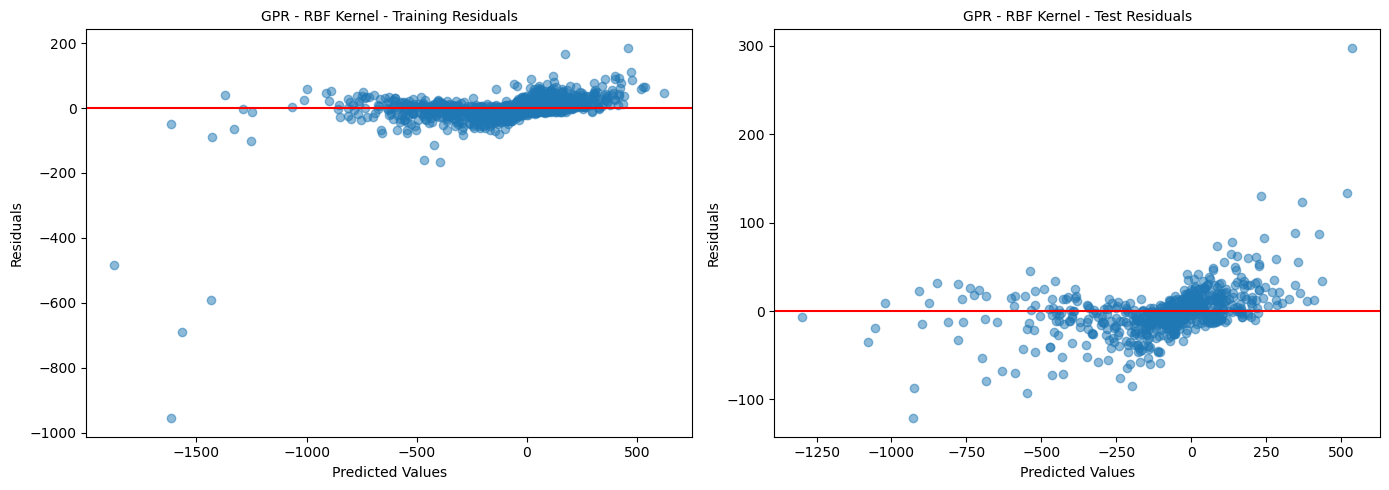

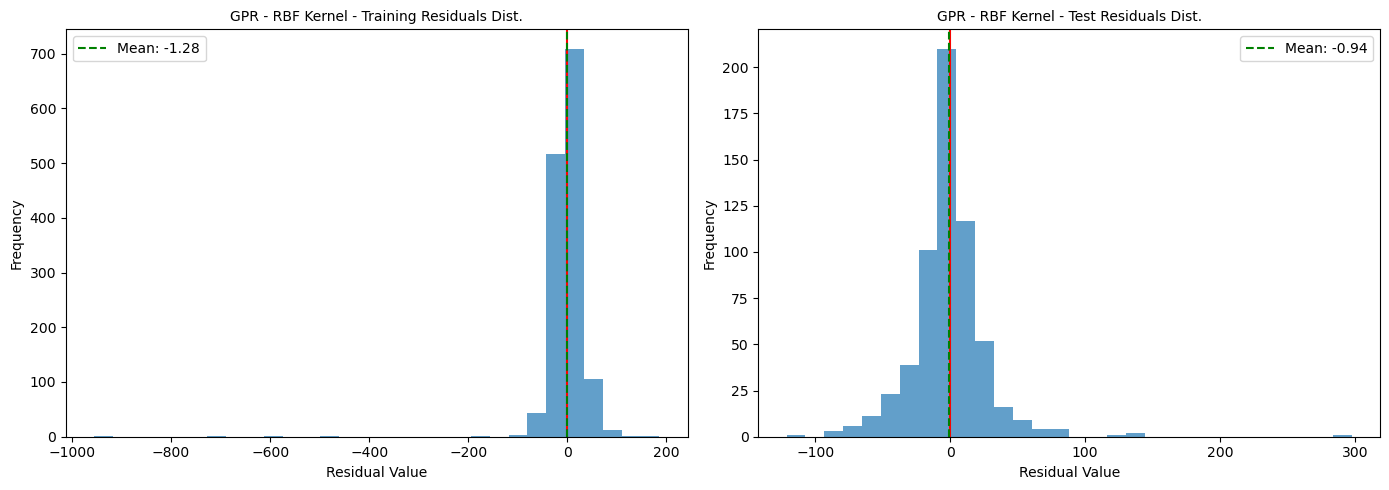


GPR - Rational Quadratic Kernel
     Metric        Value
0       MAE    23.365905
1       MSE  1498.714981
2      RMSE    38.713240
3  R² Score     0.985650


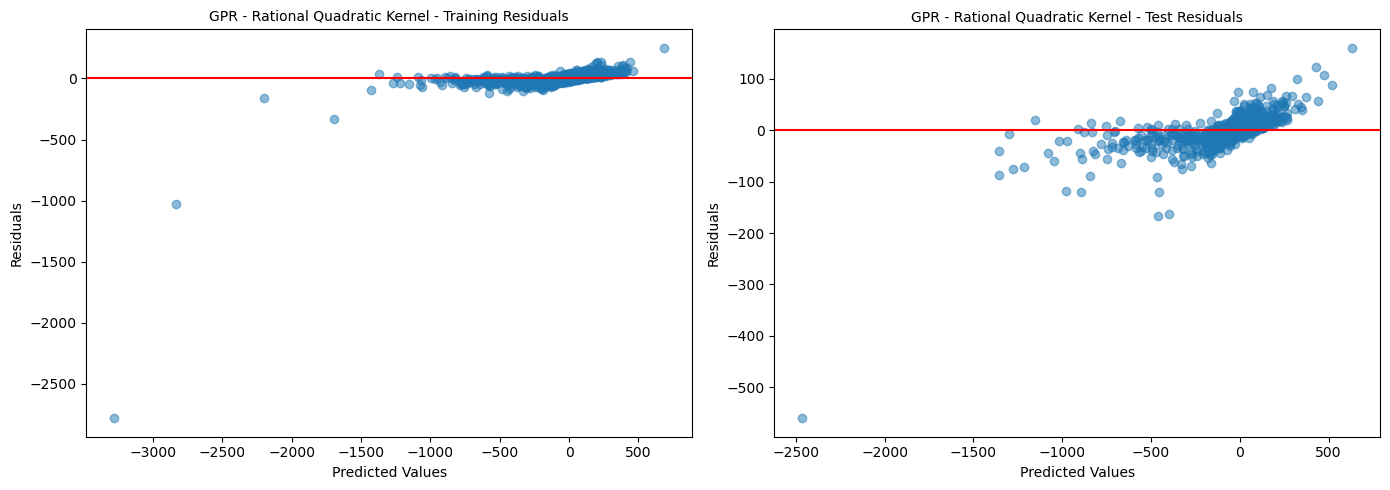

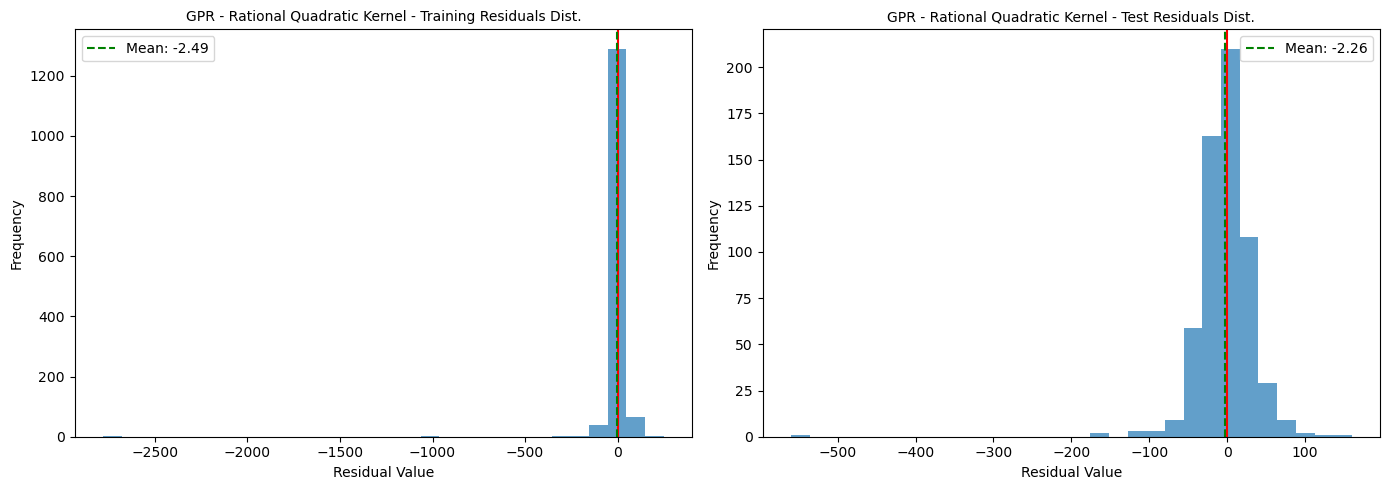


GPR - RBF + White Kernel
     Metric          Value
0       MAE     211.655677
1       MSE  114783.584980
2      RMSE     338.797262
3  R² Score      -0.101183


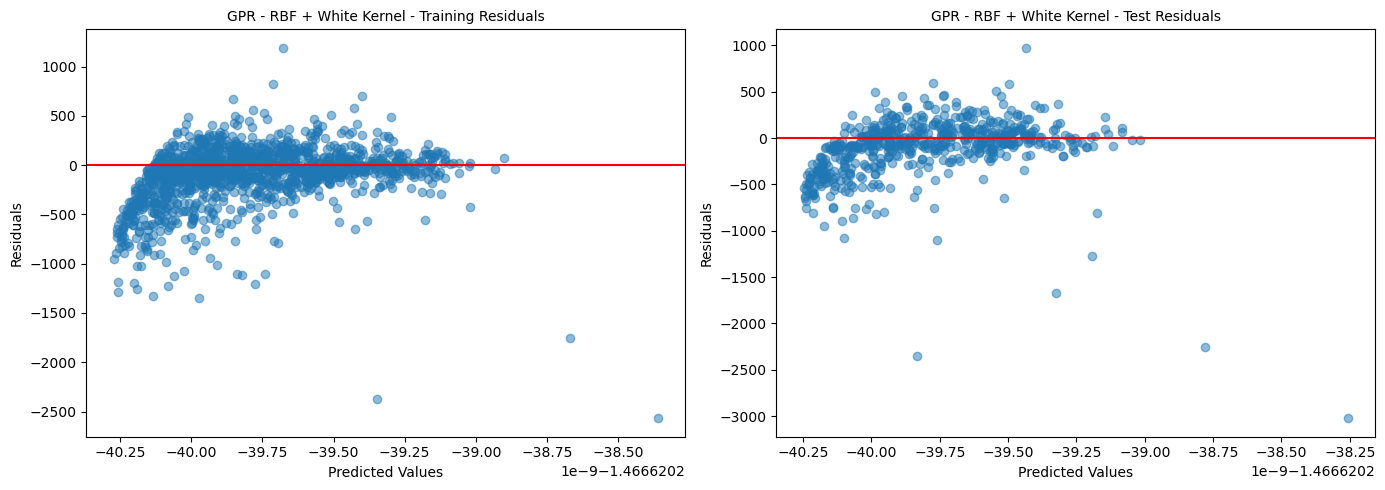

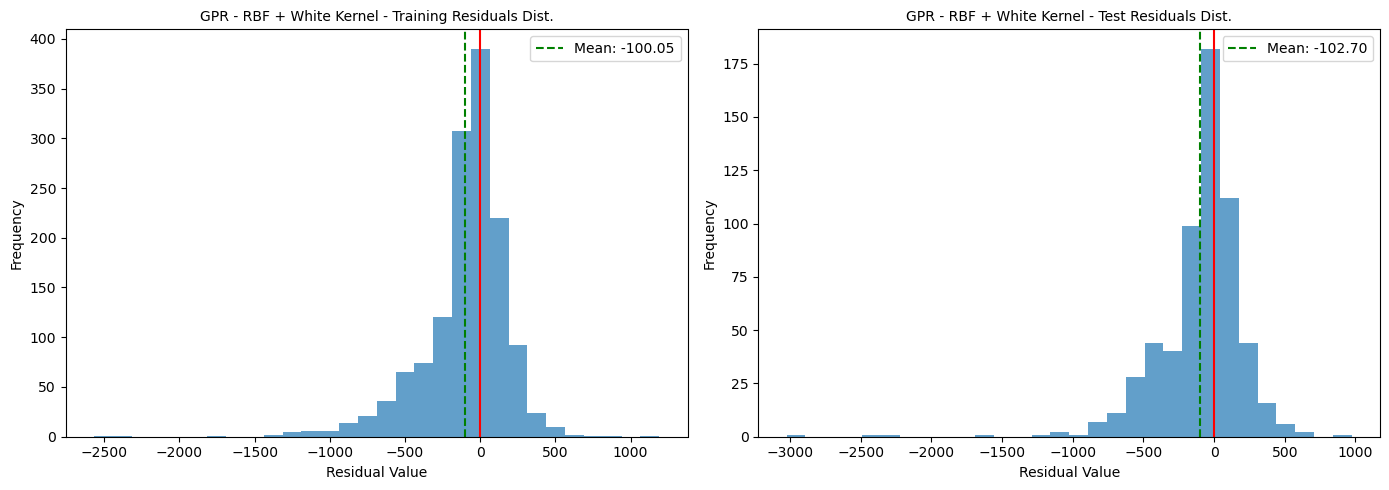

In [88]:
def gaussian(kernel, title="Gaussian Process Regressor"):
    df = pd.read_csv('Data/price_differences.csv')
    features = ['ttt', 'los', 'price_booking', 'price_expedia']
    y = df['price_difference']
    X = df[features]
    
    # 🔹 Reducing sample size to 2000 samples for faster runtime
    if len(X) > 2000:
        sampled_indices = np.random.choice(len(X), size=2000, replace=False)
        X = X.iloc[sampled_indices]
        y = y.iloc[sampled_indices]
    
    # The data distribution
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Scale features for better GPR performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Creating a Gaussian Process Regressor with increased regularization
    gpr_model = GaussianProcessRegressor(
        kernel=kernel,
        random_state=42,
        n_restarts_optimizer=1,  # Reduced from 3 to 1 for faster runtime
        alpha=1.0  # Increased regularization to prevent overfitting (was 1e-6)
    )
    
    # Print title first
    print(f"\n{title}")
    
    # Fit the model
    gpr_model.fit(X_train_scaled, y_train)
    
    # Make predictions on both train and test sets
    y_train_pred = gpr_model.predict(X_train_scaled)
    y_test_pred = gpr_model.predict(X_test_scaled)
    
    # Calculation of performance indicators
    mae_gpr = mean_absolute_error(y_test, y_test_pred)
    mse_gpr = mean_squared_error(y_test, y_test_pred)
    rmse_gpr = np.sqrt(mse_gpr)
    r2_gpr = r2_score(y_test, y_test_pred)
    
    # Presentation of results
    results_gpr = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
        "Value": [mae_gpr, mse_gpr, rmse_gpr, r2_gpr]
    })
    print(results_gpr)
    
    # Calculate residuals for both train and test sets
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    # Plot residuals
    plt.figure(figsize=(14, 5))
    
    # Training residuals
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred, residuals_train, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{title} - Training Residuals', fontsize=10)
    
    # Test residuals
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_pred, residuals_test, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{title} - Test Residuals', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Plot a residual histogram
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(residuals_train, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.axvline(x=residuals_train.mean(), color='g', linestyle='dashed', 
                label=f'Mean: {residuals_train.mean():.2f}')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{title} - Training Residuals Dist.', fontsize=10)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(residuals_test, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='-')
    plt.axvline(x=residuals_test.mean(), color='g', linestyle='dashed', 
                label=f'Mean: {residuals_test.mean():.2f}')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title(f'{title} - Test Residuals Dist.', fontsize=10)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Experiment 1: RBF kernel with standard parameters
gaussian(RBF(length_scale=1.0), "GPR - RBF Kernel")

# Experiment 2: Rational Quadratic Kernel
gaussian(RationalQuadratic(alpha=1.0), "GPR - Rational Quadratic Kernel")

# Experiment 3: RBF kernel + WhiteKernel (to handle noise)
gaussian(RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0), "GPR - RBF + White Kernel")

## Gaussian Regression Analysis Results

- Rational Quadratic kernel significantly outperforms the best previous Decision Tree model (R² = 0.91, RMSE = 89.43)
- Adding the White noise kernel overwhelmed the signal, resulting in extremely poor performance.

### Key Insights

- Kernel selection dramatically impacts model performance.
- GPR provides better modeling of the underlying relationships compared to Decision Trees for this dataset.

# Neural Network


MLP - Basic Model (10 neurons)
     Metric         Value
0       MAE    142.219963
1       MSE  51438.829526
2      RMSE    226.801300
3  R² Score      0.437381
Training R² Score: 0.436176
Test R² Score: 0.437381


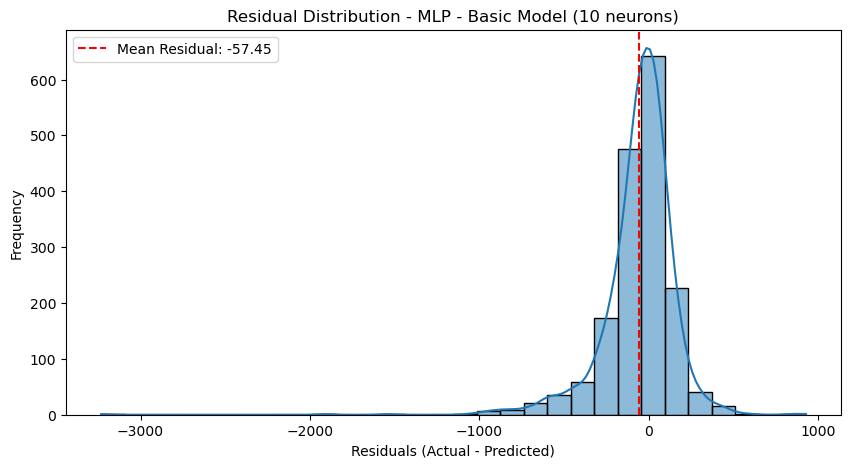

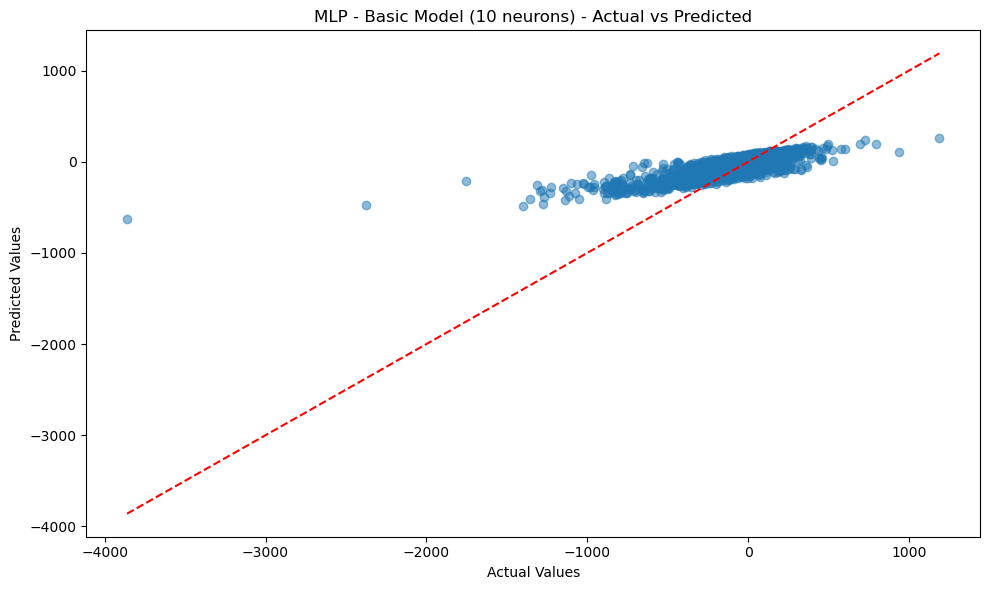


MLP - Simple Network (15,10)
     Metric       Value
0       MAE   10.880717
1       MSE  654.389919
2      RMSE   25.581046
3  R² Score    0.992843
Training R² Score: 0.993704
Test R² Score: 0.992843


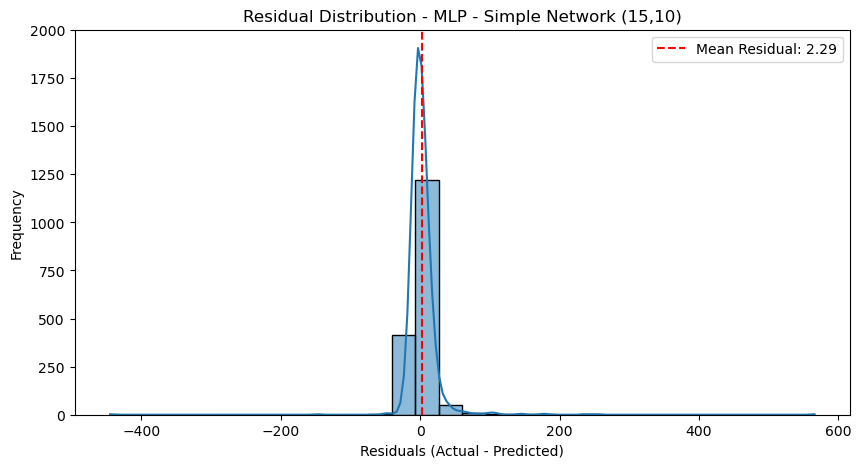

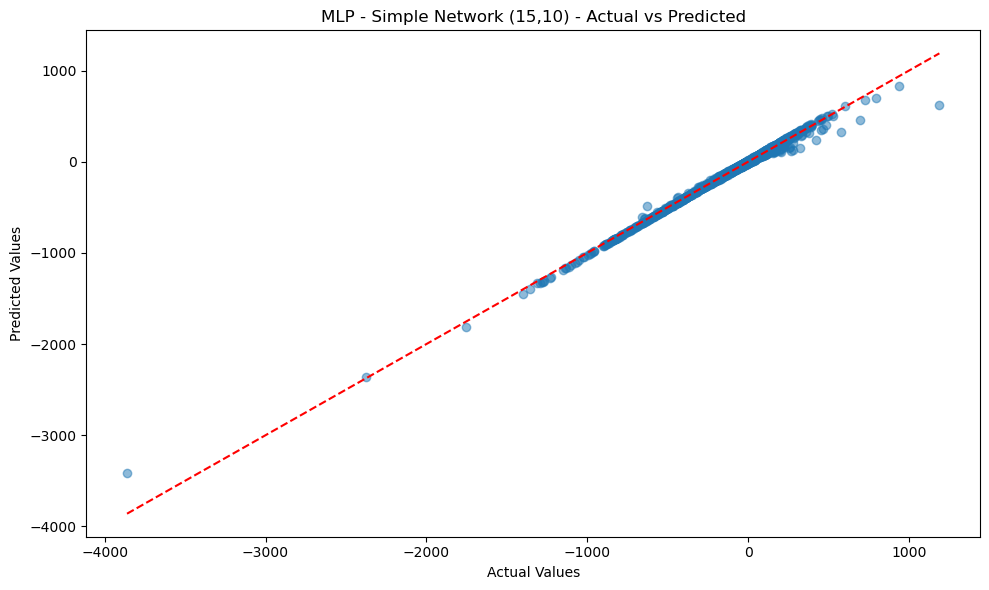


MLP - Tanh Activation
     Metric         Value
0       MAE    180.678221
1       MSE  87615.409344
2      RMSE    295.999002
3  R² Score      0.041694
Training R² Score: 0.057621
Test R² Score: 0.041694


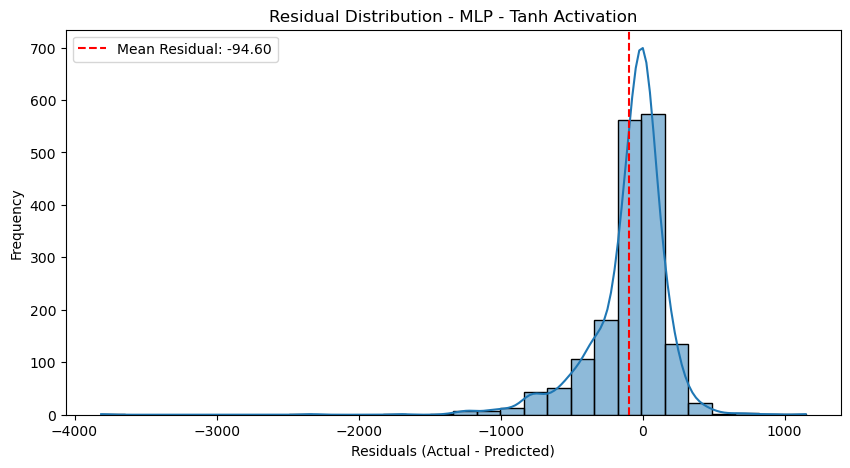

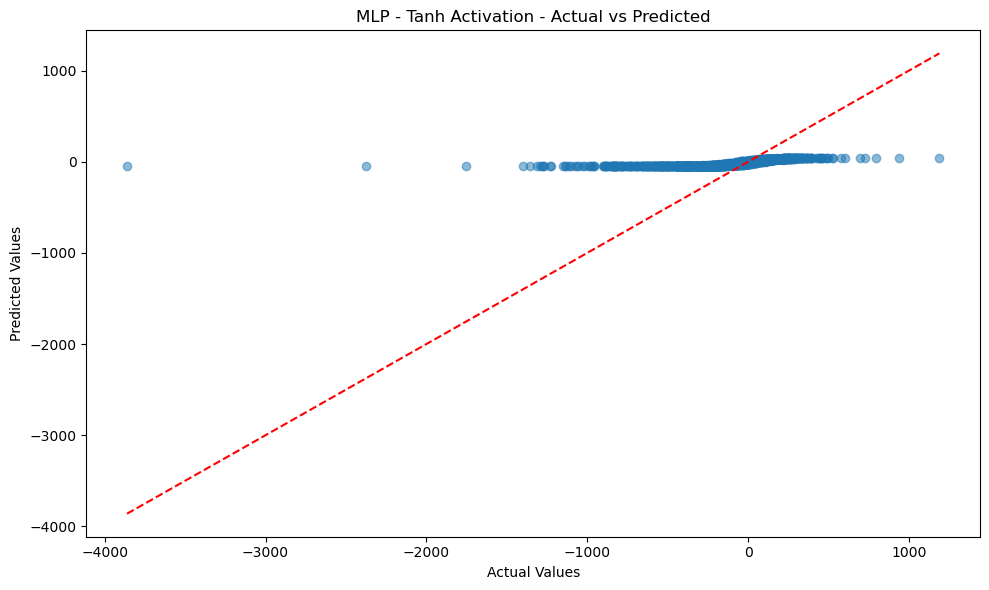


MLP - High Regularization (5 neurons)
     Metric         Value
0       MAE    163.429675
1       MSE  64200.853693
2      RMSE    253.378874
3  R² Score      0.297794
Training R² Score: 0.306850
Test R² Score: 0.297794


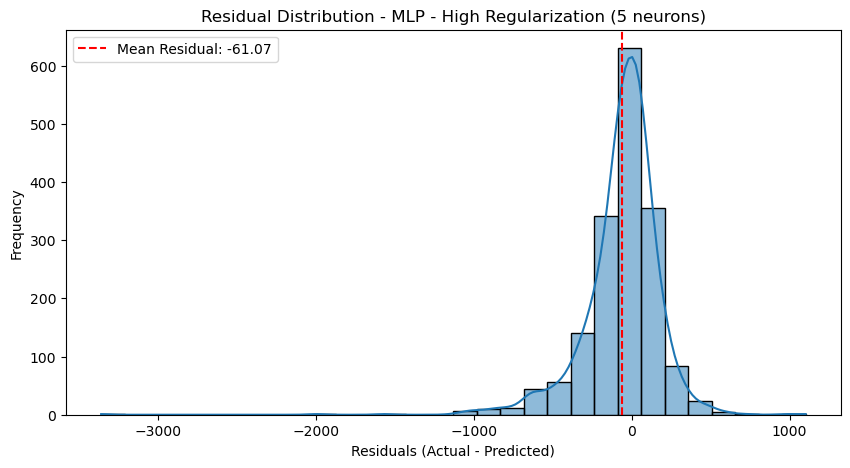

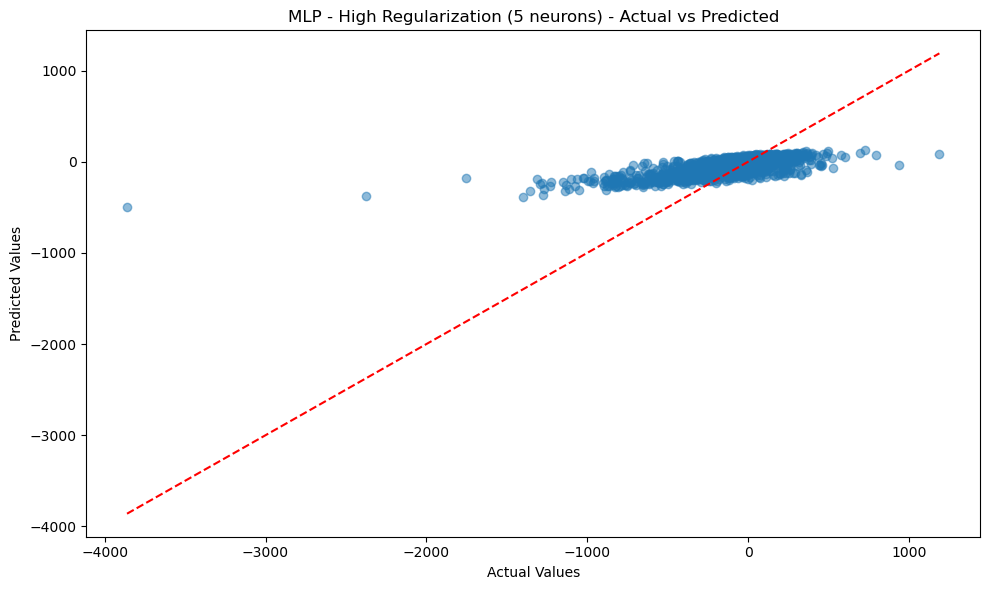

In [89]:
def mlp(hidden_layer_sizes=(10,), activation='relu', alpha=0.001, max_iter=200, title="MLP Regressor"):
    df = pd.read_csv('Data/price_differences.csv')
    features = ['ttt', 'los', 'price_booking', 'price_expedia']
    y = df['price_difference']
    X = df[features]

    # Scale the features - this helps prevent overfitting
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Create a more basic MLPRegressor with regularization (alpha)
    mlp_model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes, 
        activation=activation,
        solver='adam',
        alpha=alpha,  # L2 regularization parameter
        max_iter=max_iter,
        early_stopping=True,  # Enable early stopping
        validation_fraction=0.1,  # Use 10% of training data for validation
        n_iter_no_change=10,  # Stop training if validation score doesn't improve for 10 iterations
        random_state=42
    )
    
    # Print title first
    print(f"\n{title}")
    
    mlp_model.fit(X_train, y_train)
    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    # Calculate metrics
    mae_mlp = mean_absolute_error(y_test, y_test_pred)
    mse_mlp = mean_squared_error(y_test, y_test_pred)
    rmse_mlp = np.sqrt(mse_mlp)
    r2_mlp = r2_score(y_test, y_test_pred)

    results_mlp = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R² Score"],
        "Value": [mae_mlp, mse_mlp, rmse_mlp, r2_mlp]
    })
    print(results_mlp)
    
    # Calculate and print training metrics to check for overfitting
    train_r2 = r2_score(y_train, y_train_pred)
    print(f"Training R² Score: {train_r2:.6f}")
    print(f"Test R² Score: {r2_mlp:.6f}")

    # Calculate residuals
    residuals_mlp = y_test - y_test_pred
    
    # Plot residuals
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals_mlp, bins=30, kde=True)
    plt.axvline(residuals_mlp.mean(), color='r', linestyle='dashed', label=f'Mean Residual: {residuals_mlp.mean():.2f}')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    # Plot prediction vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{title} - Actual vs Predicted')
    plt.tight_layout()
    plt.show()

# Run experiments with more appropriate parameters
# Experiment 1: Very basic network with small hidden layer and regularization
mlp(hidden_layer_sizes=(10,), activation='relu', alpha=0.1, title="MLP - Basic Model (10 neurons)")

# Experiment 2: Slightly bigger but still simple
mlp(hidden_layer_sizes=(15, 10), activation='relu', alpha=0.01, title="MLP - Simple Network (15,10)")

# Experiment 3: Different activation function
mlp(hidden_layer_sizes=(10,), activation='tanh', alpha=0.1, title="MLP - Tanh Activation")

# Experiment 4: Tiny network with high regularization
mlp(hidden_layer_sizes=(5,), activation='relu', alpha=0.5, title="MLP - High Regularization (5 neurons)")


## Neural Network Analysis Results

- Architecture sensitivity is evident, with the Simple Network (15,10) significantly outperforming other configurations (R² = 0.993, RMSE = 25.58)
- The ReLU activation function worked substantially better than tanh for this dataset
- High regularization (alpha=0.5) led to underfitting with the simplest model
- The two-layer architecture with moderate regularization achieved exceptional performance, surpassing both Decision Tree (R² = 0.91) and Gaussian Process models (R² = 0.989)
- Minimal differences between training and test scores across configurations indicate effective regularization

### Key Insights

- Neural networks demonstrate the highest predictive power among all tested models when properly configured
- However, they require careful hyperparameter tuning to achieve optimal results
- The two-layer (15,10) architecture strikes the best balance between model complexity and generalization for this price difference prediction task